# Predicting Molecular Properties with Graph Neural Networks

This notebook provides you with a complete code example to predict the properties of small molecules using graph convolutional layers with message passing.

## Understanding Graph Convolutions

Calculate the adjacency matrix of a simple cycle graph ...

In [1]:
import numpy as np

node_num = 5

A = np.zeros((node_num, node_num))
for i in range(node_num):
    for j in range(node_num):
        if j % node_num == (i + 1) % node_num:
            A[i, j] = 1

In [2]:
print(f"A: {A}")

A: [[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]


... assign node features ...

In [3]:
x = np.zeros(node_num)
x[0] = 1

In [4]:
print("x:", x)

x: [1. 0. 0. 0. 0.]


... implement a function to perform a graph convolution ...

In [5]:
def graph_convolution(A, x):
    """Calculate graph convolution."""
    conv = np.zeros(node_num)
    for i in range(node_num):
        for j in range(node_num):
            conv[j] = conv[j] + A[i, j] * x[i]
    return conv

... and apply the graph convolution.

In [6]:
for c in range(5):
    x = graph_convolution(A, x)
    print(f"Convolution {c + 1}: ", x)

Convolution 1:  [0. 1. 0. 0. 0.]
Convolution 2:  [0. 0. 1. 0. 0.]
Convolution 3:  [0. 0. 0. 1. 0.]
Convolution 4:  [0. 0. 0. 0. 1.]
Convolution 5:  [1. 0. 0. 0. 0.]


## Predicting Molecular Properties with Graph Convolutions

### Implementing a Graph Convolution Layer

Define a class to implement a graph convolution ...

In [7]:
import torch
import torch.nn as nn

class GraphConvolution(nn.Module):
    """Graph convolution."""
    
    def forward(self, A, node_attr):
        """Compute the graph convolution."""
        return torch.matmul(A, node_attr)

... and a class to implement the class convolution layer.

In [8]:
import deeplay as dl

class GCL(dl.DeeplayModule):
    """Graph convolution layer."""
    
    def __init__(self, in_feats, out_feats):
        """Initialize graph convolution layer."""
        super().__init__()
        self.transform = dl.Layer(nn.Linear, in_feats, out_feats)
        self.propagate = dl.Layer(GraphConvolution)
        self.update = dl.Layer(nn.ReLU)

    def diagonalize(self, A):
        """Add diagonal to adjacency matrix."""
        return A + torch.eye(A.size(0)).to(A.device)

    def normalize(seft, A):
        """Normalize ajacency matrix."""
        node_degrees = torch.sum(A, dim=1)
        inv_sqrt_node_degreed = node_degrees.pow(-0.5)
        inv_sqrt_node_degreed[inv_sqrt_node_degreed == float("inf")] = 0
        degree_matrix = torch.diag(inv_sqrt_node_degreed)
        return torch.matmul(torch.matmul(degree_matrix, A), degree_matrix)

    def forward(self, A, node_attr):
        """Transform, propagate and update the node attributes."""
        A = self.normalize(self.diagonalize(A))
        transformed_node_attr = self.transform(node_attr)
        propagated_node_attr = self.propagate(A, transformed_node_attr)
        updated_node_attr = self.update(propagated_node_attr)
        return updated_node_attr

### Using the ZINC Dataset

Download the ZINC dataset ...

In [9]:
from torch_geometric.datasets import ZINC

train_set = ZINC(root="ZINC_dataset/", subset=True, split="train")
val_set = ZINC(root="ZINC_dataset/", subset=True, split="val")
test_set = ZINC(root="ZINC_dataset/", subset=True, split="test")

... implement a function to plot the adjacency matrix of a molecule ...

In [10]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
from torch_geometric.utils import to_dense_adj

def plot_molecule(molecule):
    """Plot adjacency matrix of a molecule."""
    node_attr = molecule["x"].numpy().squeeze()  # Atom type numbers.
    A = to_dense_adj(molecule["edge_index"]).numpy().squeeze(0)
    logP = molecule["y"].item()
    
    plt.matshow(A, cmap=colormaps["gray"].reversed())
    plt.title(f"LogP={np.round(logP, 2)}", fontsize=24)
    plt.xlabel("Atom type", fontsize=16); plt.ylabel("Atom type", fontsize=16)
    plt.xticks(np.arange(len(node_attr)), node_attr, fontsize=12)
    plt.yticks(np.arange(len(node_attr)), node_attr, fontsize=12)
    ax = plt.gca(); ax.xaxis.set_ticks_position("bottom")
    plt.show()

... and use to visualize the structures of some molecules.

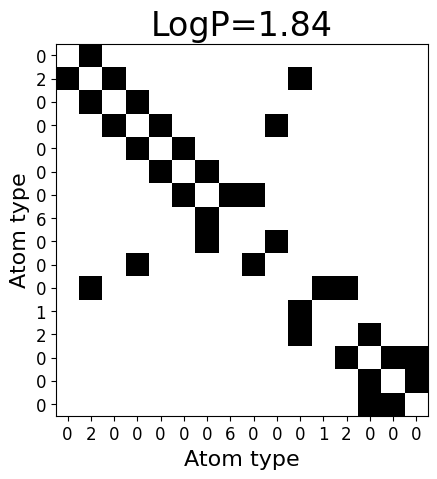

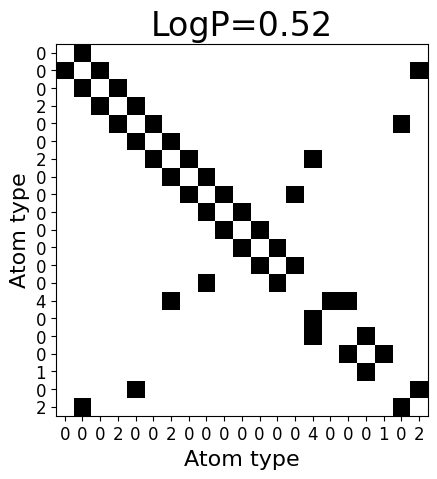

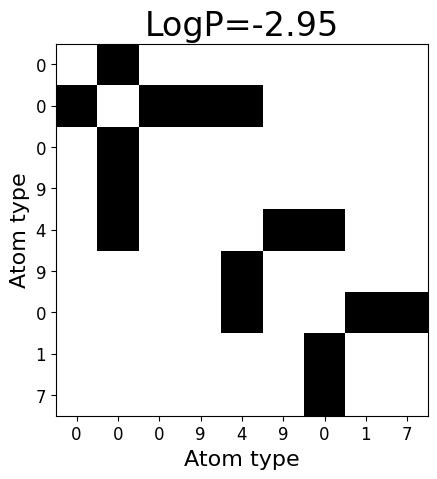

In [11]:
for molecule_index in [2, 1235, 9887]:
    plot_molecule(molecule=train_set[molecule_index])

### Implementing a Graph Convolutional Network

Create a class to implement a graph convolutional network ...

In [12]:
class GCN(dl.DeeplayModule):
    """Graph convolutional network."""
    
    def __init__(self, num_atoms, embed_dim, hidden_feats, out_feats):
        """Initialize graph convolutional network."""
        super().__init__()
        self.node_embedding = dl.Layer(nn.Embedding, num_atoms, embed_dim)
        self.blocks = dl.LayerList()
        for f_in, f_out in zip([embed_dim, *hidden_feats[:-1]], 
                               hidden_feats):
            self.blocks.append(GCL(in_feats=f_in, out_feats=f_out))
        self.dense_top = dl.Sequential(
            dl.Layer(nn.Linear, hidden_feats[-1], hidden_feats[-1] // 4),
            dl.Layer(nn.ReLU),
            dl.Layer(nn.Linear, hidden_feats[-1] // 4, out_feats),
        )

    def forward(self, G):
        """***Predict graph properties***."""
        G["node_attr"] = self.node_embedding(G["node_attr"])
        for block in self.blocks:
            G["node_attr"] = block(G["A"], G["node_attr"])
        
        num_graphs = torch.max(G["graph_ids"]) + 1
        pooled_graph_attr = torch.zeros(
            num_graphs, G["node_attr"].shape[1], device=G["node_attr"].device,
        )
        pooled_graph_attr = pooled_graph_attr.scatter_add(
            0, G["graph_ids"][:, None].expand_as(G["node_attr"]), 
            G["node_attr"], 
        )
        node_counts = torch.bincount(G["graph_ids"])
        pooled_graph_attr = pooled_graph_attr / node_counts[:, None]
        
        return self.dense_top(pooled_graph_attr).squeeze()  # LogP.

... instantiate it ...

In [13]:
gcn_model = GCN(num_atoms=28, embed_dim=64, hidden_feats=[64,] * 4, 
                out_feats=1).create()

print(gcn_model)

GCN(
  (node_embedding): Embedding(28, 64)
  (blocks): LayerList(
    (0-3): 4 x GCL(
      (transform): Linear(in_features=64, out_features=64, bias=True)
      (propagate): GraphConvolution()
      (update): ReLU()
    )
  )
  (dense_top): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)


... define the data loaders ...

In [14]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=32, shuffle=False)

... implement a class to compile, train, and evaluate the graph convolutional network ...

In [15]:
class MolecularRegressor(dl.Regressor):
    """Regressor model for molecular property prediction."""

    def __init__(self, model, **kwargs):
        """Initialize molecular regressor."""
        super().__init__(model, **kwargs)
    
    def batch_preprocess(self, G):
        """Preprocess the graph batch for model input."""
        G["node_attr"] = G["x"].squeeze()
        G["A"] = to_dense_adj(G["edge_index"]).squeeze(0)
        G["graph_ids"] = G["batch"]
        return G.to(self.device)
    
    def forward(self, G):
        """Calculate model output for input graph batch."""
        return self.model(self.batch_preprocess(G))

... and train the graph convolutional network.

In [16]:
from lightning.pytorch.callbacks import ModelCheckpoint
import os

gcn = MolecularRegressor(gcn_model, loss=nn.L1Loss(), 
                         optimizer=dl.Adam(lr=1e-3)).create()
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", dirpath=os.path.join("models", "gcn"), 
    filename="ZINC-{epoch:02d}-{val_loss:.2f}", auto_insert_metric_name=False,
)
trainer = dl.Trainer(max_epochs=400, callbacks=[checkpoint_callback])
trainer.fit(gcn, train_loader, val_loader)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/Ch11_GNN/ec11_1_gnn/models/gcn exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ L1Loss           │      0 │ train │
│ 1 │ train_metrics │ MetricCollection │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection │      0 │ train │
│ 4 │ model         │ GCN              │ 19.5 K │ train │
│ 5 │ optimizer     │ Adam             │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 19.5 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 19.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 28                                                                                          
Modules in eval mode: 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to
improve performance.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to
improve performance.

### Evaluating the Trained Graph Convolutional Network

Evaluate the performance of the trained graph convolutional network ...

In [17]:
import glob

model_paths = glob.glob(os.path.join("models", "gcn", "ZINC-*.ckpt"))
best_model_path = sorted(model_paths, key=os.path.getmtime)[-1]
gcn_best = MolecularRegressor.load_from_checkpoint(best_model_path, 
                                                   model=gcn_model)
test_results = trainer.test(gcn_best, test_loader)

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │     0.486503928899765     │
└───────────────────────────┴───────────────────────────┘

... obtain the predicted and actual logP ...

In [18]:
logP_gts, logP_preds = [], []
for G in test_loader:
    logP_gts.append(G.pop("y"))
    logP_preds.append(gcn_best(G))
logP_gts = torch.cat(logP_gts).cpu().numpy()
logP_preds = torch.cat(logP_preds).detach().cpu().numpy()

... and plot the predicted logP versus their ground truth values.

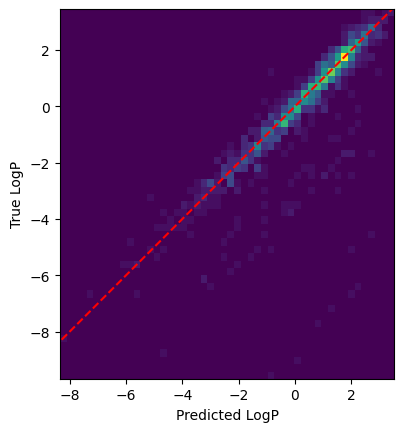

In [19]:
heatmap, xedges, yedges = np.histogram2d(logP_preds, logP_gts, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.plot([min(logP_gts), max(logP_gts)], [min(logP_gts), max(logP_gts)], "r--")
plt.imshow(heatmap.T, extent=extent, origin="lower")
plt.xlabel("Predicted LogP"); plt.ylabel("True LogP")
plt.show()

## Predicting Molecular Properties with Message Passing

### Implementing a Message Passing Layer

Implement a class to implement a layer to perform the transform step ...

In [20]:
class TransformLayer(nn.Module):
    """Transform layer."""
    
    def __init__(self, hidden_feats):
        """Initialize the transform layer."""
        super().__init__()
        self.linear = nn.LazyLinear(hidden_feats)
        self.activation = nn.ReLU()

    def forward(self, G):
        """Compute messages by transforming node and edge features."""
        src_node_attr = G["node_attr"][G["edge_index"][0]]
        tgt_node_attr = G["node_attr"][G["edge_index"][1]]
        edge_attr = G["edge_attr"]

        msg = torch.cat([src_node_attr, tgt_node_attr, edge_attr], dim=-1)
        G["msg"] = self.activation(self.linear(msg))
        return G

... a class to implement a layer to perform the propagate step ...

In [21]:
class PropagateLayer(nn.Module):
    """Propagate layer."""

    def __init__(self, hidden_feats):
        """Initialize propagate layer."""
        super().__init__()
        self.hidden_feats = hidden_feats

    def forward(self, G):
        """Aggregate messages from neighboring nodes."""
        num_nodes = G["node_attr"].size(0)
        aggregated_msg = torch.zeros(num_nodes, self.hidden_feats, 
                                     dtype=G["node_attr"].dtype,
                                     device=G["node_attr"].device)
        tgt_node_idxs = (G["edge_index"][1].unsqueeze(1).expand_as(G["msg"]))
        aggregated_msg = aggregated_msg.scatter_add(0, tgt_node_idxs, G["msg"])
        G["aggregated_msg"] = aggregated_msg
        return G

... a class to implement a layer to perform the update step ...

In [22]:
class UpdateLayer(nn.Module):
    """Update layer."""

    def __init__(self, hidden_feats):
        """Initialize update layer."""
        super().__init__()
        self.linear = nn.LazyLinear(hidden_feats)
        self.activation = nn.ReLU()

    def forward(self, G):
        """Update node attributes combining them with aggregated messages."""
        attr = torch.cat([G["node_attr"], G["aggregated_msg"]], dim=-1)
        G["node_attr"] = self.activation(self.linear(attr))
        G["edge_attr"] = G["msg"]
        return G

... and use them to define a message passing layer.

In [23]:
mpl = dl.Sequential(
    dl.Layer(TransformLayer, hidden_feats=64),
    dl.Layer(PropagateLayer, hidden_feats=64),
    dl.Layer(UpdateLayer, hidden_feats=64),
).create()

print(mpl)

Sequential(
  (0): TransformLayer(
    (linear): LazyLinear(in_features=0, out_features=64, bias=True)
    (activation): ReLU()
  )
  (1): PropagateLayer()
  (2): UpdateLayer(
    (linear): LazyLinear(in_features=0, out_features=64, bias=True)
    (activation): ReLU()
  )
)


### Implementing a Message Passing Network

Create a class to implement a message passing network ...

In [24]:
class MPN(dl.DeeplayModule):
    """Message passing network."""
    
    def __init__(self, num_atoms, num_edge_embed, embed_dim, hidden_feats, 
                 out_feats):
        """Initialize message passing network."""
        super().__init__()
        self.node_embedding = dl.Layer(nn.Embedding, num_atoms, embed_dim)
        self.edge_embedding = dl.Layer(nn.Embedding, num_edge_embed, embed_dim)
        self.blocks = dl.LayerList()
        for f_out in hidden_feats:
            mpl = dl.Sequential(
                dl.Layer(TransformLayer, f_out),
                dl.Layer(PropagateLayer, f_out),
                dl.Layer(UpdateLayer, f_out),
            )
            self.blocks.append(mpl)
        self.dense_top = dl.Sequential(
            dl.Layer(nn.Linear, hidden_feats[-1], hidden_feats[-1] // 4),
            dl.Layer(nn.ReLU),
            dl.Layer(nn.Linear, hidden_feats[-1] // 4, out_feats),
        )

    def forward(self, G):
        """Predict graph properties."""
        G["node_attr"] = self.node_embedding(G["node_attr"])
        G["edge_attr"] = self.edge_embedding(G["edge_attr"])
        for block in self.blocks:
            G = block(G)
        
        num_graphs = torch.max(G["graph_ids"]) + 1
        pooled_graph_attr = torch.zeros(
            num_graphs, G["node_attr"].shape[1], device=G["node_attr"].device,
        )
        pooled_graph_attr = pooled_graph_attr.scatter_add(
            0, G["graph_ids"][:, None].expand_as(G["node_attr"]), 
            G["node_attr"],
        )
        node_counts = torch.bincount(G["graph_ids"])
        pooled_graph_attr = pooled_graph_attr / node_counts[:, None]
        
        return self.dense_top(pooled_graph_attr).squeeze()  # LogP.

... instantiate the message passing network ...

In [25]:
mpn_model = MPN(num_atoms=28, num_edge_embed=4, embed_dim=64, 
                hidden_feats=[64,] * 4, out_feats=1).create()

print(mpn_model)

MPN(
  (node_embedding): Embedding(28, 64)
  (edge_embedding): Embedding(4, 64)
  (blocks): LayerList(
    (0-3): 4 x Sequential(
      (0): TransformLayer(
        (linear): LazyLinear(in_features=0, out_features=64, bias=True)
        (activation): ReLU()
      )
      (1): PropagateLayer()
      (2): UpdateLayer(
        (linear): LazyLinear(in_features=0, out_features=64, bias=True)
        (activation): ReLU()
      )
    )
  )
  (dense_top): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)


... train the message passing network ...

In [26]:
mpn = MolecularRegressor(mpn_model, loss=nn.L1Loss(), 
                         optimizer=dl.Adam(lr=1e-3)).create()
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", dirpath=os.path.join("models", "mpn"), 
    filename="ZINC-{epoch:02d}-{val_loss:.2f}", auto_insert_metric_name=False,
)
trainer = dl.Trainer(max_epochs=400, callbacks=[checkpoint_callback])
trainer.fit(mpn, train_loader, val_loader)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/Ch11_GNN/ec11_1_gnn/models/mpn exists and is not empty.
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:477: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example_input_array` in your LightningModule.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ L1Loss           │      0 │ train │
│ 1 │ train_metrics │ MetricCollection │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection │      0 │ train │
│ 4 │ model         │ MPN              │  3.1 K │ train │
│ 5 │ optimizer     │ Adam             │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 3.1 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.1 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 45                                                                                          
Modules in eval mode: 0

Output()

... evaluate the performance of the trained message passing network ...

In [27]:
model_paths = glob.glob(os.path.join("models", "mpn", "ZINC-*.ckpt"))
best_model_path = sorted(model_paths, key=os.path.getmtime)[-1]
mpn_best = MolecularRegressor.load_from_checkpoint(best_model_path, 
                                                   model=mpn_model)
test_results = trainer.test(mpn_best, test_loader)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.23601101338863373    │
└───────────────────────────┴───────────────────────────┘

... obtaining the predicted and actual logP ...

In [28]:
logP_gts, logP_preds = [], []
for G in test_loader:
    logP_gts.append(G.pop("y"))
    logP_preds.append(mpn_best(G))
logP_gts = torch.cat(logP_gts).cpu().numpy()
logP_preds = torch.cat(logP_preds).detach().cpu().numpy()

... and plot the predicted logP versus their ground truth values.

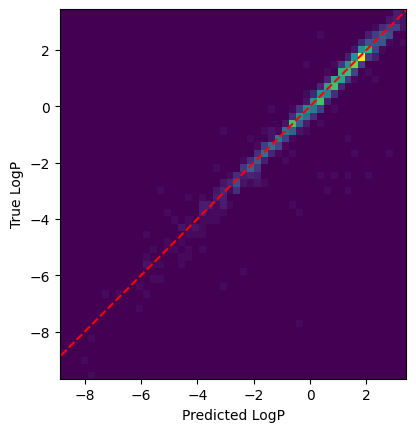

In [29]:
heatmap, xedges, yedges = np.histogram2d(logP_preds, logP_gts, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.plot([min(logP_gts), max(logP_gts)], [min(logP_gts), max(logP_gts)], "r--")
plt.imshow(heatmap.T, extent=extent, origin="lower")
plt.xlabel("Predicted LogP"); plt.ylabel("True LogP")
plt.show()